# AWS Glue Studio Notebook (University Ranking Notebook)
##### You are now running a AWS Glue Studio notebook; To start using your notebook you need to start an AWS Glue Interactive Session.


#### Optional: Run this cell to see available notebook commands ("magics").


In [ ]:
%help

####  Run this cell to set up and start your interactive session.


In [18]:
%idle_timeout 2880
%glue_version 4.0
%worker_type G.1X
%number_of_workers 5

import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
from awsglue.dynamicframe import DynamicFrame
  
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

You are already connected to a glueetl session c77b9645-85e5-4e14-aeb5-1ad2cd4eddaf.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Current idle_timeout is 2880 minutes.
idle_timeout has been set to 2880 minutes.


You are already connected to a glueetl session c77b9645-85e5-4e14-aeb5-1ad2cd4eddaf.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Setting Glue version to: 4.0


You are already connected to a glueetl session c77b9645-85e5-4e14-aeb5-1ad2cd4eddaf.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Previous worker type: G.1X
Setting new worker type to: G.1X


You are already connected to a glueetl session c77b9645-85e5-4e14-aeb5-1ad2cd4eddaf.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Previous number of workers: 5
Setting new number of workers to: 5



#### Example: Create a DynamicFrame from a table in the AWS Glue Data Catalog and display its schema


In [4]:
dyf = glueContext.create_dynamic_frame.from_catalog(database='suan_workshop_datalake_robin_ranking_universities_db', table_name='university_ranking_csv_all_strings')
dyf.printSchema()

root
|-- university: string
|-- year: string
|-- rank_display: string
|-- score: string
|-- link: string
|-- country: string
|-- city: string
|-- region: string
|-- logo: string
|-- type: string
|-- research_output: string
|-- student_faculty_ratio: string
|-- international_students: string
|-- size: string
|-- faculty_count: string


#### Example: Convert the DynamicFrame to a Spark DataFrame and display a sample of the data


In [4]:
rankings_df = dyf.toDF()
# df.show()
rankings_df.show(5)

+--------------------+----+------------+-----+--------------------+--------------+---------+-------------+--------------------+-------+---------------+---------------------+----------------------+----+-------------+
|          university|year|rank_display|score|                link|       country|     city|       region|                logo|   type|research_output|student_faculty_ratio|international_students|size|faculty_count|
+--------------------+----+------------+-----+--------------------+--------------+---------+-------------+--------------------+-------+---------------+---------------------+----------------------+----+-------------+
|Massachusetts Ins...|2017|           1|  100|https://www.topun...| United States|Cambridge|North America|https://www.topun...|Private|      Very High|                    4|                 3,730|   M|        3,065|
| Stanford University|2017|           2| 98.7|https://www.topun...| United States| Stanford|North America|https://www.topun...|Private| 

# Create or replace view for Querying

In [ ]:
rankings_df.createOrReplaceTempView("university_ranking") 

# First: SIMPLE

In [7]:
spark.sql("""SELECT university,year,rank_display,region,country FROM university_ranking""").show(5)

+--------------------+----+------------+-------------+--------------+
|          university|year|rank_display|       region|       country|
+--------------------+----+------------+-------------+--------------+
|Massachusetts Ins...|2017|           1|North America| United States|
| Stanford University|2017|           2|North America| United States|
|  Harvard University|2017|           3|North America| United States|
|University of Cam...|2017|           4|       Europe|United Kingdom|
|California Instit...|2017|           5|North America| United States|
+--------------------+----+------------+-------------+--------------+
only showing top 5 rows


# Query: RANKS

In [8]:
spark.sql("""SELECT university,year,rank_display, int(rank_display) as n_rank,region,country 
FROM university_ranking""").show(5)

+--------------------+----+------------+------+-------------+--------------+
|          university|year|rank_display|n_rank|       region|       country|
+--------------------+----+------------+------+-------------+--------------+
|Massachusetts Ins...|2017|           1|     1|North America| United States|
| Stanford University|2017|           2|     2|North America| United States|
|  Harvard University|2017|           3|     3|North America| United States|
|University of Cam...|2017|           4|     4|       Europe|United Kingdom|
|California Instit...|2017|           5|     5|North America| United States|
+--------------------+----+------------+------+-------------+--------------+
only showing top 5 rows


# Query: SPLIT the rank_display data and get the first value

In [9]:
spark.sql("""SELECT university,year,rank_display, int(split(rank_display,'-')[0]) as n_rank,region,country 
FROM university_ranking
WHERE rank_display like '%-%'""").show(5)

+--------------------+----+------------+------+-------------+--------------------+
|          university|year|rank_display|n_rank|       region|             country|
+--------------------+----+------------+------+-------------+--------------------+
|Bandung Institute...|2017|     401-410|   401|         Asia|           Indonesia|
| Brandeis University|2017|     401-410|   401|North America|       United States|
|Illinois Institut...|2017|     401-410|   401|North America|       United States|
|Johannes Gutenber...|2017|     401-410|   401|       Europe|             Germany|
|Khalifa Universit...|2017|     401-410|   401|         Asia|United Arab Emirates|
+--------------------+----+------------+------+-------------+--------------------+
only showing top 5 rows


# Query: Complete

In [10]:
spark.sql("""SELECT 
    university,
    coalesce(int(year),9999) as year,
    rank_display,
    coalesce(int(split(rank_display,'-')[0]),9999) as n_rank,
    coalesce(float(score),-1) as score,
    country, city, region, type,
    research_output,
    coalesce(float(student_faculty_ratio),-1) as student_faculty_ratio,
    coalesce(int(regexp_replace(international_students,'[.,]','')),-1) as international_students,
    size,
    coalesce(int(regexp_replace(faculty_count,'[.,]','')),-1) as faculty_count
    FROM university_ranking""").show(5)

+--------------------+----+------------+------+-----+--------------+---------+-------------+-------+---------------+---------------------+----------------------+----+-------------+
|          university|year|rank_display|n_rank|score|       country|     city|       region|   type|research_output|student_faculty_ratio|international_students|size|faculty_count|
+--------------------+----+------------+------+-----+--------------+---------+-------------+-------+---------------+---------------------+----------------------+----+-------------+
|Massachusetts Ins...|2017|           1|     1|100.0| United States|Cambridge|North America|Private|      Very High|                  4.0|                  3730|   M|         3065|
| Stanford University|2017|           2|     2| 98.7| United States| Stanford|North America|Private|      Very High|                  3.0|                  3879|   L|         4725|
|  Harvard University|2017|           3|     3| 98.3| United States|Cambridge|North America|Pri

# Let's Store the results data frame

In [12]:
clean_rankings_df = spark.sql("""SELECT 
    university,
    coalesce(int(year),9999) as year,
    rank_display,
    coalesce(int(split(rank_display,'-')[0]),9999) as n_rank,
    coalesce(float(score),-1) as score,
    country, city, region, type,
    research_output,
    coalesce(float(student_faculty_ratio),-1) as student_faculty_ratio,
    coalesce(int(regexp_replace(international_students,'[.,]','')),-1) as international_students,
    size,
    coalesce(int(regexp_replace(faculty_count,'[.,]','')),-1) as faculty_count
    FROM university_ranking""")

clean_rankings_df.show(5)

+--------------------+----+------------+------+-----+--------------+---------+-------------+-------+---------------+---------------------+----------------------+----+-------------+
|          university|year|rank_display|n_rank|score|       country|     city|       region|   type|research_output|student_faculty_ratio|international_students|size|faculty_count|
+--------------------+----+------------+------+-----+--------------+---------+-------------+-------+---------------+---------------------+----------------------+----+-------------+
|Massachusetts Ins...|2017|           1|     1|100.0| United States|Cambridge|North America|Private|      Very High|                  4.0|                  3730|   M|         3065|
| Stanford University|2017|           2|     2| 98.7| United States| Stanford|North America|Private|      Very High|                  3.0|                  3879|   L|         4725|
|  Harvard University|2017|           3|     3| 98.3| United States|Cambridge|North America|Pri

# Convert back to DynamicFrame

In [19]:
clean_dynamic_frame = DynamicFrame.fromDF(clean_rankings_df, glueContext, "university_ranking_clean")

# Store the clean data back to S3

In [20]:
university_ranking_destn = glueContext.write_dynamic_frame.from_options(
    frame=clean_dynamic_frame,
    connection_type="s3",
    format="csv",
    connection_options={
        "path": "s3://suan-workshop-datalake-robin-deletable-us-east-1/university_ranking/csv_clean/",
        "partitionKeys": [],
    },
    transformation_ctx="university_ranking_dest",
)

# Commit the job

In [21]:
job.commit()

#### Example: Visualize data with matplotlib


<BarContainer object of 5 artists>



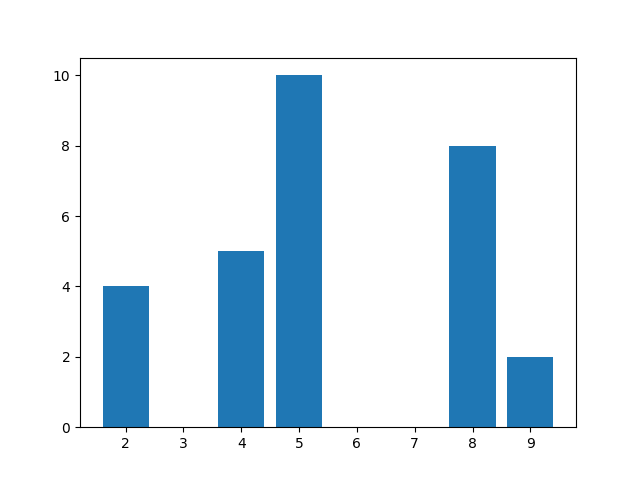

In [7]:
import matplotlib.pyplot as plt

# Set X-axis and Y-axis values
x = [5, 2, 8, 4, 9]
y = [10, 4, 8, 5, 2]
  
# Create a bar chart 
plt.bar(x, y)
  
# Show the plot
%matplot plt

#### Example: Write the data in the DynamicFrame to a location in Amazon S3 and a table for it in the AWS Glue Data Catalog


In [24]:
s3output = glueContext.getSink(
  path="s3://suan-workshop-datalake-robin-deletable-us-east-1/university_ranking/parquet_clean/",
  connection_type="s3",
  updateBehavior="UPDATE_IN_DATABASE",
  partitionKeys=[],
  compression="snappy",
  enableUpdateCatalog=True,
  transformation_ctx="s3output",
)
s3output.setCatalogInfo(
  catalogDatabase="suan_workshop_datalake_robin_ranking_universities_db", catalogTableName="university_ranking_parquet_clean"
)
s3output.setFormat("glueparquet")
s3output.writeFrame(clean_dynamic_frame)

In [25]:
job.commit()